In [60]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random


discount_factor = 0.9 #change this to change the DF everywhere. 

In [111]:
# TRANSITIONS (Actions,States,States)
# REWARDS     (Actions,States,States)

Histories: $\mathcal{H} = [h_{-1}, h_{-2}, h_{-3}, h_{-4}]$. For the $(5,5)$ constraint, we only need to see that last four epoch's worth of withdrawals.

In [241]:
# construct possible histories
all_combinations = itertools.product(range(6), repeat=4)
histories = np.asarray([combination for combination in all_combinations if sum(combination) <= 5])
histories[-1], len(histories)

(array([5, 0, 0, 0]), 126)

Pendings: $\mathcal{P} = [p_{1}, p_{10}]$. We only track the number of each value of withdrawals, where at most there are 20 pending at a time.

In [243]:
# construct pendings
all_combinations = itertools.product(range(11), repeat=2)
pendings = np.asarray([combination for combination in all_combinations if sum(combination) <= 20])
pendings[-1], len(pendings)

(array([10, 10]), 121)

In [244]:
def tostr(arr):
    return ','.join(str(x) for x in arr)

Full state $\mathcal{S} = [\mathcal{P}, \mathcal{H}] = [p_{1}, p_{10}, h_{-1}, h_{-2}, h_{-3}, h_{-4}]$

In [245]:
states = []
stateInds = {}
ind = 0
for i in tqdm(range(len(pendings))):
    for j in range(len(histories)):
        p, h = pendings[i], histories[j]
        full = np.concatenate((p,h))
        states.append(full)
        strrep = tostr(full)
        stateInds[strrep] = ind
        ind += 1
states = np.asarray(states)
len(stateInds), len(states)

100%|██████████| 121/121 [00:00<00:00, 477.95it/s]


(15246, 15246)

In [246]:
# reward for a state is the negative of the sum of the values.
def getReward(state, hiVal):
    p1, p10 = state[0], state[1]
    return - (p1 + p10*hiVal)

Distribution for arrivals $X \sim [0, 1, 5] \; w.p. \; [0.5, 0.4, 0.1]$. 

Distribution of values $Y \sim [1, 10] \; w.p. \;  [0.9, 0.1]$.

In [275]:
# all the values and probabilities for potential new pendings
numProbs = {0:0.5, 1:0.4, 5:0.1}
valProbs = {1:0.9, 10:0.1}
newPendings = [
    (0,0),
    (1,0),(0,1),
    (5,0),(4,1),(3,2),(2,3),(1,4),(0,5)]
newPendingProbs = [
    (valProbs[1]**ones)*(valProbs[10]**tens)*math.comb(ones+tens,ones)*numProbs[ones+tens]
    for (ones,tens) in newPendings]

In [254]:
# all the values and probabilities for potential new pendings
numProbs = {0:0.4, 1:0.4, 2:0.2}
valProbs = {1:0.9, 10:0.1}
newPendings = [
    (0,0),
    (1,0),(0,1),
    (2,0),(1,1),(0,2)]
newPendingProbs = [
    (valProbs[1]**ones)*(valProbs[10]**tens)*math.comb(ones+tens,ones)*numProbs[ones+tens]
    for (ones,tens) in newPendings]

In [315]:
# all the values and probabilities for potential new pendings
numProbs = {0:0.6, 1:0.1, 10:0.08}
valProbs = {1:0.9, 10:0.1}
newPendings = [
    (0,0),
    (1,0),(0,1),
    (10,0),(9,1),(8,2),(7,3),(6,4),(5,5),(4,6),(3,7),(2,8),(1,9),(0,10)]
newPendingProbs = [
    (valProbs[1]**ones)*(valProbs[10]**tens)*math.comb(ones+tens,ones)*numProbs[ones+tens]
    for (ones,tens) in newPendings]

In [316]:
newPendings, newPendingProbs, sum(newPendingProbs)

([(0, 0),
  (1, 0),
  (0, 1),
  (10, 0),
  (9, 1),
  (8, 2),
  (7, 3),
  (6, 4),
  (5, 5),
  (4, 6),
  (3, 7),
  (2, 8),
  (1, 9),
  (0, 10)],
 [0.6,
  0.315,
  0.034999999999999996,
  0.017433922005000005,
  0.01937102445000001,
  0.009685512225000005,
  0.0028697814000000015,
  0.0005580130500000001,
  7.440174000000003e-05,
  6.889050000000004e-06,
  4.3740000000000025e-07,
  1.8225000000000013e-08,
  4.5000000000000026e-10,
  5.000000000000003e-12],
 1.0000000000000002)

demo transtitions from initial state

```
0 [0 0 0 0 0 0] [0 0 0 0 0 0] 0.5 0 0
1 [0 0 0 0 0 0] [1 0 0 0 0 0] 0.36000000000000004 1386 -1
2 [0 0 0 0 0 0] [0 1 0 0 0 0] 0.04000000000000001 126 -10
3 [0 0 0 0 0 0] [5 0 0 0 0 0] 0.05904900000000001 6930 -5
4 [0 0 0 0 0 0] [4 1 0 0 0 0] 0.032805 5670 -14
5 [0 0 0 0 0 0] [3 2 0 0 0 0] 0.007290000000000002 4410 -23
6 [0 0 0 0 0 0] [2 3 0 0 0 0] 0.0008100000000000004 3150 -32
7 [0 0 0 0 0 0] [1 4 0 0 0 0] 4.500000000000001e-05 1890 -41
8 [0 0 0 0 0 0] [0 5 0 0 0 0] 1.0000000000000004e-06 630 -50
```

In [317]:
transitions = [lil_matrix((15246,15246), dtype=float) for _ in range(6)]
rewards = [lil_matrix((15246,15246), dtype=float) for _ in range(6)]

In [318]:
# action = a, pop a (if possible), reward from newstate
for a in range(6):
    for curInd, state in tqdm(enumerate(states)):
        interState = np.copy(state)
        if sum(interState[2:]) + a > 5: # illegal action: violation of constraint
            transitions[a][curInd, curInd] += 1 # stay 
            rewards[a][curInd, curInd] = -10000 # big penalty
        elif sum(interState[:2]) < a:   # illegal action: not enough to process
            transitions[a][curInd, curInd] += 1 # stay
            rewards[a][curInd, curInd] = -10000 # big penalty
        else: # legal action: process
            p1, p10 = interState[0], interState[1]
            remTens = a - p10
            if remTens <= 0:  # only 10s consumed
                p10 -= a
            else:             # use the remainder to process 1s
                p10 = 0
                p1 -= remTens
            interState[0] = p1
            interState[1] = p10

            # shift history
            interState[3:6] = interState[2:5]
            interState[2] = a

            # new pendings
            for i, (ones, tens) in enumerate(newPendings):
                newState = np.copy(interState)
                # add new withdrawals
                newState[0] += ones
                newState[1] += tens
                prob = newPendingProbs[i]
                try:
                    newInd = stateInds[tostr(newState)]
                except KeyError: # not a valid new state, leave state alone
                    newInd = curInd
                transitions[a][curInd, newInd] += prob
                # rewards[a][curInd, newInd] = getReward(states[newInd])
                rewards[a][curInd, newInd] = getReward(states[curInd], hiVal=10)

15246it [00:06, 2267.26it/s]
15246it [00:04, 3565.39it/s]
15246it [00:02, 7419.04it/s]
15246it [00:01, 13607.07it/s]
15246it [00:00, 26097.75it/s]
15246it [00:00, 33270.91it/s]


In [319]:
transitions = np.asarray([
    csr_matrix(transitions[0]),
    csr_matrix(transitions[1]),
    csr_matrix(transitions[2]),
    csr_matrix(transitions[3]),
    csr_matrix(transitions[4]),
    csr_matrix(transitions[5]),
])
rewards = np.asarray([
    csr_matrix(rewards[0]),
    csr_matrix(rewards[1]),
    csr_matrix(rewards[2]),
    csr_matrix(rewards[3]),
    csr_matrix(rewards[4]),
    csr_matrix(rewards[5]),
])
transitions[1].shape

(15246, 15246)

In [280]:
util.check(transitions, rewards)

In [320]:
dis = 0.9
vi = mdp.ValueIteration(transitions, rewards, discount=dis)
vi.run()
vi.iter

44

In [321]:
vi.V[0], vi.policy[0]

(-24.882971413911697, 0)

In [322]:
opt_policy = np.asarray(vi.policy)
opt_policy.shape

(15246,)

---- 
---
---

`PRIO-MINSLACK`

In [323]:
# PRIO-MINSLACK
# stationary distribution
prio_transitions = lil_matrix((15246,15246), dtype=float)
prio_rewards = lil_matrix((15246,15246), dtype=float)
prio_policy = []
for i, state in enumerate(states):
    slack = 5 - sum(state[2:])
    avail = sum(state[:2])
    policy = 6
    if slack <= avail:
        policy = slack
    else: # avail > slack => can only do avail
        policy = avail
    prio_policy.append(policy)
    prio_transitions[i] = transitions[policy][i]
    prio_rewards[i] = rewards[policy][i]

In [324]:
prio_transitions = csr_matrix(prio_transitions)
prio_rewards = csr_matrix(prio_rewards)
prio_policy = np.asarray(prio_policy)

In [327]:
np.argwhere(prio_policy - opt_policy > 1)

array([[2818],
       [2853],
       [2873],
       [2883],
       [2969],
       [2989],
       [3080],
       [3150],
       [4194],
       [4219],
       [4229],
       [4249],
       [4305],
       [4340],
       [4410],
       [5544],
       [5545],
       [5550],
       [5565],
       [5600],
       [5635],
       [5670],
       [5726],
       [5796],
       [6930],
       [6986],
       [7056],
       [8316]])

In [328]:
ind = 11088 
states[ind], prio_policy[ind], opt_policy[ind]

(array([8, 0, 0, 0, 0, 0]), 5, 4)

---- 
---
---

`simulations`

In [329]:
# sims
def sim_both(n=None):
    prio_state = np.array([0, 0, 0, 0, 0, 0])
    opti_state = np.array([0, 0, 0, 0, 0, 0])
    prio_rewards, opti_rewards = [], []
    for curTime in range(n):
        
        # add rewards for existing state
        prio_rewards.append(getReward(prio_state, hiVal=10))
        opti_rewards.append(getReward(opti_state, hiVal=10))
        
        # get actions
        try:
            prioStateInd = stateInds[tostr(prio_state)]
            prio_action = prio_policy[prioStateInd] 
        except KeyError:
            # just use all capacity if we are getting long.
            slack = 5 - sum(prio_state[2:])
            prio_action = slack
        try:
            optiStateInd = stateInds[tostr(opti_state)]
            opti_action = opt_policy[optiStateInd]
        except KeyError:
            # just use all capacity if we are getting long.
            slack = 5 - sum(opti_state[2:])
            opti_action = slack

        # process withdrawals
        p1, p10 = prio_state[0], prio_state[1]
        remTens = prio_action - p10
        if remTens <= 0:  # only 10s consumed
            p10 -= prio_action
        else:             # use the remainder to process 1s
            p10 = 0
            p1 -= remTens
        prio_state[0] = p1
        prio_state[1] = p10
        
        p1, p10 = opti_state[0], opti_state[1]
        remTens = opti_action - p10
        if remTens <= 0:  # only 10s consumed
            p10 -= opti_action
        else:             # use the remainder to process 1s
            p10 = 0
            p1 -= remTens
        opti_state[0] = p1
        opti_state[1] = p10
        
        # shift history
        prio_state[3:6] = prio_state[2:5]
        prio_state[2] = prio_action
        opti_state[3:6] = opti_state[2:5]
        opti_state[2] = opti_action

        # Add new pendings
        (newOnes, newTens) = random.choices(newPendings, weights=newPendingProbs,k=1)[0]
        prio_state[0] += newOnes
        prio_state[1] += newTens
        opti_state[0] += newOnes
        opti_state[1] += newTens

    prio_rewards = np.asarray(prio_rewards)
    opti_rewards = np.asarray(opti_rewards)
    return prio_rewards, opti_rewards

In [330]:
def discounted_sum(payoffs, delta):
    discount_factors = np.array([delta**t for t in range(len(payoffs))])
    discounted_payoffs = np.dot(payoffs, discount_factors)
    return (1-delta) * discounted_payoffs

In [331]:
def MCMCcomparison(no_trials, no_iters, dis):
    prio_avg = []
    opti_avg = []

    for _ in tqdm(range(no_trials)):
        prio_r, opti_r = sim_both(no_iters)
        prio_avg.append(discounted_sum(prio_r, dis))
        opti_avg.append(discounted_sum(opti_r, dis))

    print("Optimal Discounted Reward: ", sum(opti_avg)/no_trials)
    print("Prio-minslack Discounted Reward: ", sum(prio_avg)/no_trials)

    return prio_avg, opti_avg

In [332]:
prio_avg, opti_avg = MCMCcomparison(10000, 350, 0.9)

100%|██████████| 10000/10000 [01:47<00:00, 93.10it/s]

Optimal Discounted Reward:  -3.610810201239759
Prio-minslack Discounted Reward:  -3.620320137887266


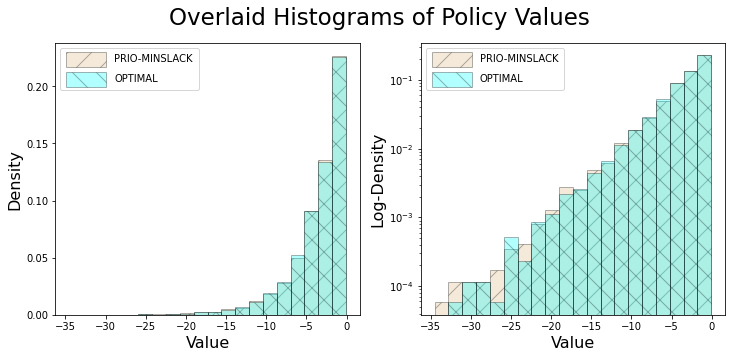

In [333]:
f, axarr = plt.subplots(ncols = 2, figsize=(12,5))

ax, ax2 = axarr
bins=np.histogram(np.hstack((prio_avg,opti_avg)), bins=20)[1] 

ax.hist(prio_avg, bins, alpha=0.3, label='PRIO-MINSLACK', density=True,
        hatch='/', edgecolor='k',fill=True, color='burlywood')  
ax.hist(opti_avg, bins, alpha=0.3, label='OPTIMAL',density=True,
        hatch='\\', edgecolor='k',fill=True, color='aqua')
ax2.hist(prio_avg, bins, alpha=0.3, label='PRIO-MINSLACK', log=True, density=True,
        hatch='/', edgecolor='k',fill=True, color='burlywood')  
ax2.hist(opti_avg, bins, alpha=0.3, label='OPTIMAL', log=True, density=True,
        hatch='\\', edgecolor='k',fill=True, color='aqua')

ax.set_ylabel('Density', size=16)
ax2.set_ylabel('Log-Density', size=16)

for ax in axarr: 
    leg = ax.legend(loc=2, labelspacing=1., handlelength=4, borderpad=0.6)
    for patch in leg.get_patches():
        patch.set_height(15)
        patch.set_y(-4.5)
    ax.set_xlabel('Value', size=16)

f.suptitle('Overlaid Histograms of Policy Values', size=23)
# plt.savefig("histo.png", dpi = 400)
plt.show()